In [15]:
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter
import scipy
import os
import re
from pathlib import Path
from collections import Counter, defaultdict


class UTDMHAD():
    def __init__(self, train, validation, test, current_directory):
        self.train_participant = train
        self.validation_participant = validation
        self.test_participant = test

        self.training = None
        self.test = None
        self.validation = None

        self.training_cleaned = None
        self.test_cleaned = None
        self.validation_cleaned = None

        self.training_normalized = None
        self.test_normalized = None
        self.validation_normalized = None

        self.training_normalized_segmented = None
        self.test_normalized_segmented = None
        self.validation_normalized_segmented = None

        self.training_final = None
        self.validation_final = None
        self.test_final = None

        self.missing_synthetic   = 0
        self.total_files         = 0
        self.GRAVITY             = 9.80665 
        self.frequency_real      = 50 #Hz
        self.frequency_synthetic = 50 #Hz (We did interpolation for this)

        self.training_sensor_participant, self.validation_sensor_participant, self.test_sensor_participant = None, None, None

        self.PATH = current_directory

        self.headers = [ ]



        self.dataset_name = 'UTD-MHAD'

    def get_datasets(self):
        training     = {a: {"Real": pd.DataFrame(), "Synthetic": pd.DataFrame()} for a in self.train_participant}
        test         = {a: {"Real": pd.DataFrame(), "Synthetic": pd.DataFrame()} for a in self.test_participant}
        validation   = {a: {"Real": pd.DataFrame(), "Synthetic": pd.DataFrame()} for a in self.validation_participant}


        base_dir     = os.path.join(self.PATH, f"datasets/{self.dataset_name}/normal")
        dataset_path = Path(base_dir)
        pattern      = re.compile(r'^a(\d+)_s(\d+)_t(\d+)_inertial\.mat$', re.IGNORECASE)


        print(f"The base directory is {base_dir}")
        # Walk through the dataset folder (including subdirectories if any)
        for root, dirs, files in os.walk(dataset_path):
            self.total_files = len(files)
            print(f"The directory contains {len(files)} numer of files")
            for file in files:
                match = pattern.match(file)
                if match:
                    # Extract numbers from the filename.
                    activity = int(match.group(1))
                    subject  = int(match.group(2))
                    time     = int(match.group(3))



                    synthetic_data_dir = f'a{activity}_s{subject}_t{time}_color'
                    if activity >= 1 and activity <= 21:
                        synthetic_data_path = os.path.join(base_dir, 'smpl',synthetic_data_dir,'SyntheticIMU','right_wrist.npz')
                    elif activity >=22 and activity <=27:
                        synthetic_data_path = os.path.join(base_dir, 'smpl',synthetic_data_dir,'SyntheticIMU','right_thigh.npz')

                    try:
                        numpy_synthetic_data = np.load(synthetic_data_path)
                        synthetic_local_acceleration     = numpy_synthetic_data['local_accel'] / self.GRAVITY
                        synthetic_local_angular_velocity = numpy_synthetic_data['angular_velocity'] * (180.0 / np.pi)

                        assert synthetic_local_acceleration.shape == synthetic_local_angular_velocity.shape


                        self.headers = ['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']

                        df_synthetic = pd.DataFrame(
                            data=np.hstack([synthetic_local_acceleration, synthetic_local_angular_velocity]),                         # combine (N,3)+(N,3) → (N,6)
                            columns=['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']
                        )
                        df_synthetic["activityID"] = activity


                        # print(f"The synthetic data structure is {numpy_synthetic_data}")

                        # time number is available as match.group(3) if needed.
                        file_path = Path(root) / file
                        try:
                            mat = scipy.io.loadmat(file_path)
                        except Exception as e:
                            print(f"Error loading {file_path}: {e}")
                            continue
                        # print(mat["d_iner"].shape)

                        # Get the sensor data (adjust the key if necessary)
                        if "d_iner" in mat:
                            sensor_data = mat["d_iner"]
                        else:
                            print(f"Key 'sensor_readings' not found in {file_path}. Skipping file.")
                            continue

                        # Remove any extra dimensions
                        sensor_data = sensor_data.squeeze()

                        # Ensure sensor_data is 2D (each row is a sample, columns are channels)
                        if sensor_data.ndim == 1:
                            sensor_data = sensor_data.reshape(1, -1)


                        df_real               = pd.DataFrame(sensor_data, columns=self.headers)
                        df_real["activityID"] = activity


                        # Group the file based on the volunteer's membership.
                        if subject in training:
                            if training[subject]['Real'].empty:
                                training[subject]['Real']        = df_real.astype(float)
                                training[subject]['Synthetic']   = df_synthetic.astype(float)
                            else:
                                training[subject]['Real']        = pd.concat([training[subject]['Real'],      df_real     ],ignore_index=True).astype(float)
                                training[subject]['Synthetic']   = pd.concat([training[subject]['Synthetic'], df_synthetic],ignore_index=True).astype(float)
                        elif subject in validation:
                            if validation[subject]['Real'].empty:
                                validation[subject]['Real']      = df_real.astype(float)
                                validation[subject]['Synthetic'] = df_synthetic.astype(float)
                            else:
                                validation[subject]['Real']      = pd.concat([validation[subject]['Real'],      df_real     ],ignore_index=True).astype(float)
                                validation[subject]['Synthetic'] = pd.concat([validation[subject]['Synthetic'], df_synthetic],ignore_index=True).astype(float)
                        elif subject in test:
                            if test[subject]['Real'].empty:
                                test[subject]['Real']            = df_real.astype(float)
                                test[subject]['Synthetic']       = df_synthetic.astype(float)
                            else:
                                test[subject]['Real']            = pd.concat([test[subject]['Real'],      df_real     ], ignore_index=True).astype(float)
                                test[subject]['Synthetic']       = pd.concat([test[subject]['Synthetic'], df_synthetic], ignore_index=True).astype(float)
                        else:
                            print(f"Volunteer {subject}  is not assigned to any split.")
                    except Exception as e:
                        self.missing_synthetic += 1
                        print(f"Error reading the file: {e}")
                        


                    

        print(f"We are missing {self.missing_synthetic} out of {self.total_files}")

        # Optionally, assign the dictionaries to instance attributes.
        self.training = training
        self.validation = validation
        self.test = test

        return training, validation, test
    

    def segment_data(self, data_dict, window_size, overlap):
        """
        Segments the data into fixed-width windows with overlapping and assigns the 
        majority label to each segment (if multiple labels exist in the segment).

        :param data_dict: Dictionary with participant ID as keys and DataFrames as values.
                        Assumes that the label is in the second column (index 1).
        :param window_size: The size of each window (number of rows).
        :param overlap: The overlap between consecutive windows (number of rows).
        :return: A dictionary with the same keys as data_dict and values as lists of segmented DataFrames.
        """
        segmented_data = defaultdict(dict)

        for participant_id, dictionary in data_dict.items():
            for k,df in dictionary.items():
                num_rows = len(df)
                segments = []
                start = 0

                while start < num_rows:
                    end = start + window_size
                    if end > num_rows:
                        break

                    segment = df.iloc[start:end, :].copy()  # Make a copy to avoid modifying the original

                    # Calculate the majority label in this segment
                    label_counts = Counter(segment.iloc[:, -1])
                    majority_label = label_counts.most_common(1)[0][0]
                    
                    # Replace all labels in the segment with the majority label
                    segment.iloc[:, -1] = majority_label

                    segments.append(segment)
                    start += overlap

                segmented_data[participant_id][k] = segments

        return segmented_data

    def clean_nan(self, data):
        data_clean = {a: {'Real': 0, 'Synthetic':0} for a in data.keys()}
        for a in data.keys():
            for k in ['Real','Synthetic']:
                data_aux      = data[a][k].ffill(axis=0).bfill(axis=0)
                data_clean[a][k] = data_aux
        return data_clean

    def preprocessing(self):

        training_cleaned_aux = self.clean_nan(self.training)
        test_cleaned_aux = self.clean_nan(self.test)
        validation_cleaned_aux = self.clean_nan(self.validation)

        self.training_cleaned = training_cleaned_aux
        self.test_cleaned = test_cleaned_aux
        self.validation_cleaned = validation_cleaned_aux

    def data_segmentation(self):
        train_data_segmented = self.segment_data(self.training_cleaned, 50, 25)
        validation_data_segmented = self.segment_data(self.validation_cleaned, 50, 25 )
        test_data_segmented = self.segment_data(self.test_cleaned, 50, 25)

        self.training_normalized_segmented = train_data_segmented
        self.test_normalized_segmented = test_data_segmented
        self.validation_normalized_segmented = validation_data_segmented

    def prepare_dataset(self):
        '''

        This function is assuming that the signals has been synchronized somehow and that we have the same windows of real samples and synthetic samples. Please,be aware that if this assumption is not fullfilled
        there will be missalignment in th signals
        
        '''

        training, validation, testing = [], [], []

        for a in self.training_normalized_segmented.keys():
            for real, synthetic in zip(self.training_normalized_segmented[a]['Real'],self.training_normalized_segmented[a]['Synthetic']):
                training.append(((np.transpose(real.iloc[:, 0:-1].to_numpy()), np.transpose(synthetic.iloc[:, 0:-1].to_numpy())), (int(real.iloc[0, -1])-1,int(synthetic.iloc[0, -1])-1), int(a)))
        for a in self.validation_normalized_segmented.keys():
            for real, synthetic in zip(self.validation_normalized_segmented[a]['Real'],self.validation_normalized_segmented[a]['Synthetic']):
                validation.append(((np.transpose(real.iloc[:, 0:-1].to_numpy()), np.transpose(synthetic.iloc[:, 0:-1].to_numpy())), (int(real.iloc[0, -1])-1,int(synthetic.iloc[0, -1])-1), int(a)))
        for a in self.test_normalized_segmented.keys():
            for real, synthetic in zip(self.test_normalized_segmented[a]['Real'],self.test_normalized_segmented[a]['Synthetic']):
                testing.append(((np.transpose(real.iloc[:, 0:-1].to_numpy()), np.transpose(synthetic.iloc[:, 0:-1].to_numpy())), (int(real.iloc[0, -1])-1,int(synthetic.iloc[0, -1])-1), int(a)))

        self.training_final = training
        self.validation_final = validation
        self.testing_final = testing


In [17]:
dataset_object = UTDMHAD(train = [1,2,3], validation = [4,5,6], test=[7,8], current_directory = '/mimer/NOBACKUP/groups/focs/')

dataset_object.get_datasets()
dataset_object.preprocessing()
dataset_object.data_segmentation()
dataset_object.prepare_dataset()

The base directory is /mimer/NOBACKUP/groups/focs/datasets/UTD-MHAD/normal
The directory contains 862 numer of files
Error reading the file: [Errno 2] No such file or directory: '/mimer/NOBACKUP/groups/focs/datasets/UTD-MHAD/normal/smpl/a20_s6_t2_color/SyntheticIMU/right_wrist.npz'
Error reading the file: [Errno 2] No such file or directory: '/mimer/NOBACKUP/groups/focs/datasets/UTD-MHAD/normal/smpl/a3_s3_t2_color/SyntheticIMU/right_wrist.npz'
Error reading the file: [Errno 2] No such file or directory: '/mimer/NOBACKUP/groups/focs/datasets/UTD-MHAD/normal/smpl/a2_s6_t2_color/SyntheticIMU/right_wrist.npz'
Error reading the file: [Errno 2] No such file or directory: '/mimer/NOBACKUP/groups/focs/datasets/UTD-MHAD/normal/smpl/a7_s1_t3_color/SyntheticIMU/right_wrist.npz'
Error reading the file: [Errno 2] No such file or directory: '/mimer/NOBACKUP/groups/focs/datasets/UTD-MHAD/normal/smpl/a4_s1_t4_color/SyntheticIMU/right_wrist.npz'
Error reading the file: [Errno 2] No such file or directo

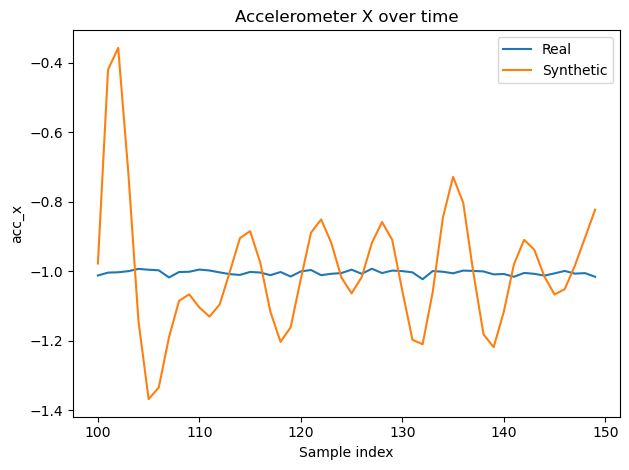

In [25]:
import matplotlib.pyplot as plt

df_real      = dataset_object.training_normalized_segmented[1]['Real']
df_synthetic = dataset_object.training_normalized_segmented[1]['Synthetic']

plt.figure()
plt.plot(df_real[4]['acc_x'], label = 'Real')
plt.plot(df_synthetic[4]['acc_y'],label = 'Synthetic')
plt.xlabel('Sample index')        # or 'Time (s)' if you have a time column
plt.ylabel('acc_x')
plt.title('Accelerometer X over time')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
df[0]

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,activityID
0,1.557770,0.175978,0.027611,156.732937,-10.994289,-23.554919,24.0
1,1.858107,0.478504,0.063850,140.687941,-3.760490,-22.732566,24.0
2,2.112223,0.750056,0.080810,125.724350,2.639058,-21.832873,24.0
3,2.019280,0.700303,0.042512,111.730586,8.207952,-20.913252,24.0
4,1.921772,0.643902,0.004305,98.723306,13.016568,-20.032758,24.0
5,1.824126,0.579671,-0.033434,86.881078,16.980176,-19.101420,24.0
6,1.722176,0.511356,-0.070534,75.823752,20.196150,-18.272252,24.0
7,1.618813,0.439354,-0.107102,66.144670,22.578385,-17.433233,24.0
8,1.514585,0.363401,-0.142818,57.185373,24.206188,-16.660007,24.0
9,1.409087,0.284635,-0.177508,49.317588,25.073986,-16.004011,24.0
